In [2]:
import csv
import networkx as nx 
import numpy as np
import pandas as pd 
import community 
from itertools import compress
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import color_palette, set_style, palplot
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [3]:
## read pre-processed data from stata
df = pd.read_stata('../data/0_CPIS_CDIS_BIS_USTIC_merged_fixed1.dta')
keep_var = ['countrycode','counterpart_code','country','counterpart','year','CDIS_IAD','CPIS_IAP','loans_dep']
df = df[keep_var]                           ## keep only used variables 
df = df.replace(np.nan,0)                   ## turn na to zero 
num = df._get_numeric_data()
num[num < 0] = 0                            ## turn negative to zero 
df['total'] = df[['CDIS_IAD','CPIS_IAP','loans_dep']].sum(axis=1)
df.describe()

,countrycode,counterpart_code,year,CDIS_IAD,CPIS_IAP,loans_dep,total
count,102611.000000,102611.000000,102611.000000,1.026110e+05,1.026110e+05,1.026110e+05,1.026110e+05
mean,448.978973,459.162506,2011.827367,2.274913e+03,3.019251e+03,1.636379e+03,6.930741e+03
std,286.647552,296.652344,2.220511,2.192672e+04,3.130591e+04,2.060122e+04,6.117723e+04
min,111.000000,111.000000,2008.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,176.000000,176.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
50%,419.000000,423.000000,2012.000000,1.082549e-01,0.000000e+00,1.000000e+00,2.658900e+01
75%,666.000000,686.000000,2014.000000,4.144426e+01,3.022868e+01,4.900000e+01,3.830000e+02
max,968.000000,968.000000,2015.000000,1.115748e+06,1.816922e+06,1.288868e+06,2.767445e+06


#### Create Weights

In [4]:
mata = ['countrycode','counterpart_code','country','counterpart','year']
var_org = ['CDIS_IAD','CPIS_IAP','loans_dep','total']
var_sum_out = ['CDIS_Sum_out','CPIS_Sum_out','loans_dep_Sum_out','total_Sum_out']
var_sum_in = ['CDIS_Sum_in','CPIS_Sum_in','loans_dep_Sum_in','total_Sum_in']
var_weight = ['CDIS_weight','CPIS_weight','loans_dep_weight','total_weight']

df[var_sum_out]= df.groupby(['countrycode','year'])[var_org].transform(sum)           ## like stata egen sum 
df[var_sum_in]= df.groupby(['counterpart_code','year'])[var_org].transform(sum)        ## like stata egen sum 
df_weight = pd.DataFrame(df[var_org].values / df[var_sum_out].values,columns=[var_weight])
df[var_weight] = df_weight                                                        ## create the weight variables 
mata.extend(var_weight)
df = df[mata]
df.fillna(0,inplace=True)

In [7]:
var = 'total_weight'
var_dist= 'distance'
year = 2015
df_graph = df[(df['year']==year) & (df[var]>0)]
df_graph[var_dist] = 1-df_graph[var]
df_graph.describe()

,countrycode,counterpart_code,year,CDIS_weight,CPIS_weight,loans_dep_weight,total_weight,distance
count,14724.000000,14724.000000,14724.0,14724.000000,14724.000000,14724.000000,1.472400e+04,14724.000000
mean,460.082458,463.137726,2015.0,0.015621,0.013991,0.014262,1.575659e-02,0.984243
std,287.263519,294.702209,0.0,0.071635,0.094508,0.064865,6.673913e-02,0.066739
min,111.000000,111.000000,2015.0,0.000000,0.000000,0.000000,2.125193e-12,0.000000
25%,178.000000,178.000000,2015.0,0.000000,0.000000,0.000000,2.475127e-05,0.996202
50%,436.000000,433.000000,2015.0,0.000021,0.000000,0.000009,3.752597e-04,0.999625
75%,676.000000,686.000000,2015.0,0.001938,0.000269,0.001260,3.798455e-03,0.999975
max,968.000000,968.000000,2015.0,1.000000,1.000000,0.988296,1.000000e+00,1.000000


#### so we have tow counterpart countries that don't have a origin, they are absorbing nodes, we need to take care of them. They are ['Curacao', 'Sint Maarten']

## Load network

In [8]:
## read from pandas datafrme 
G = nx.from_pandas_dataframe(df_graph, source="country", target="counterpart", edge_attr=[var,var_dist],create_using=nx.DiGraph()) ##,'CPIS_IAP','loans_dep'

In [9]:
# print out one particular edge, just to make sure it wroks 
G['United States']['United Kingdom']

{'distance': 0.8556067518854873, 'total_weight': 0.14439324811451276}

In [10]:
G['United Kingdom']['United States']

{'distance': 0.7488585353996706, 'total_weight': 0.25114146460032943}

In [11]:
# make sure the graph is created correctly 
df_graph[(df_graph.country == 'United States') & (df_graph.counterpart == 'United Kingdom')]

,countrycode,counterpart_code,country,counterpart,year,CDIS_weight,CPIS_weight,loans_dep_weight,total_weight,distance
2420,111.0,112.0,United States,United Kingdom,2015,0.122431,0.132708,0.235789,0.144393,0.855607


In [12]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 234
Number of edges: 14724
Average in degree:  62.9231
Average out degree:  62.9231


In [13]:
## density 
nx.density(G)

0.2700561241333774

## Diameter and radius

## Explore Degrees 

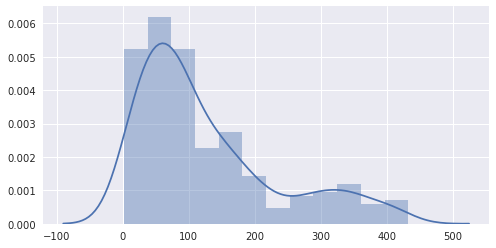

In [14]:
# Degree distribution
k = G.degree()
k =np.array(list(k.values()))
sns.set(rc={"figure.figsize": (8, 4)})
ax = sns.distplot(k)

In [15]:
# Find nodes with highest degree, unweighted 
k=G.degree()                                 ## get the degree centrality for all countries 
k = pd.DataFrame(list(k.items()),columns=['country','degree'])      ## make it into dataframe
k.sort_values(by='degree',ascending=0,inplace=True)                 ## sort it 
print('unweighted:')
k.head(5)

unweighted:


,country,degree
184,Italy,432
119,Switzerland,413
222,India,409
83,United Kingdom,406
72,Belgium,405


## Centrality measures

In [20]:
### Weighted degree centrality 
### This is the sum of both in and out folows 
d=nx.degree_centrality(G)                                 ## get the degree centrality for all countries 
degree = pd.DataFrame(list(d.items()),columns=['country','degree'])      ## make it into dataframe
degree.sort_values(by='degree',ascending=0,inplace=True)                 ## sort it 
degree.head(10)
## because it is a directd graph, centrality will be between 0,2

,country,degree
184,Italy,1.854077
119,Switzerland,1.772532
222,India,1.755365
83,United Kingdom,1.742489
72,Belgium,1.738197
89,France,1.708155
90,Luxembourg,1.690987
47,Canada,1.660944
6,Germany,1.583691
137,"Korea, Republic of",1.557940


In [28]:
## closeness
## nx.shortest_path_length(G)['United States']
c=nx.closeness_centrality(G,distance =var_dist )#distance ='rev_CDIS_IAD'                                  ## use CDIS_IAD data as distance mearuse, so the order should be reversed
closeness = pd.DataFrame(list(c.items()),columns=['country','closeness'])      ## make it into dataframe
closeness.sort_values(by='closeness',ascending=0,inplace=True)    
closeness.head(10)

,country,closeness
184,Italy,0.961128
119,Switzerland,0.906211
83,United Kingdom,0.893864
137,"Korea, Republic of",0.892141
72,Belgium,0.886118
6,Germany,0.882041
89,France,0.881285
90,Luxembourg,0.876449
222,India,0.873990
47,Canada,0.861893


In [25]:
## betweeness 
b = nx.betweenness_centrality(G,weight=var_dist)  # weight='total_weight'
between = pd.DataFrame(list(b.items()),columns=['country','between'])      ## make it into dataframe
between.sort_values(by='between',ascending=0,inplace=True)    
between.head(10)

,country,between
115,United States,0.174560
83,United Kingdom,0.116268
89,France,0.080861
119,Switzerland,0.046452
184,Italy,0.041605
228,"China, P.R.: Hong Kong",0.032651
224,Australia,0.030209
90,Luxembourg,0.030135
39,"China, P.R.: Mainland",0.023901
132,Sub-Saharan Africa,0.019221


In [22]:
## eigenvector centrality 
e = nx.eigenvector_centrality_numpy(G,weight='total_wight')
eigenvector = pd.DataFrame(list(e.items()),columns=['country','total'])      ## make it into dataframe
eigenvector.sort_values(by='total',ascending=0,inplace=True)    
eigenvector.head(10)

,country,total
187,Italy,0.170125
198,"China, P.R.: Mainland",0.157853
172,Germany,0.154358
17,Thailand,0.151023
92,Sub-Saharan Africa,0.150115
59,Bulgaria,0.144382
14,Russian Federation,0.142383
37,France,0.139213
4,Mexico,0.137618
168,"Korea, Republic of",0.137465


#### Basic clustering 

Tutorial: 
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [24]:
node_list = G.nodes()
node_list.sort()
A = nx.to_numpy_matrix(G = G,nodelist=node_list,weight='total_weight')

In [25]:
from scipy.spatial.distance import pdist, squareform
M = pdist(A, 'cosine')                 # it will return a vector, this is using cosine distance
M = squareform(M)    
NaNs = np.isnan(M)
M[NaNs] = 1                           # so, there are nan values in distance matrix as there are absorbing nodes. we set there distance to be very big
                                        # so we just seperate them out as its own cluster

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


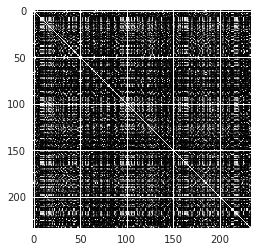

In [26]:
plt.imshow(M,cmap="Greys",interpolation="none")

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


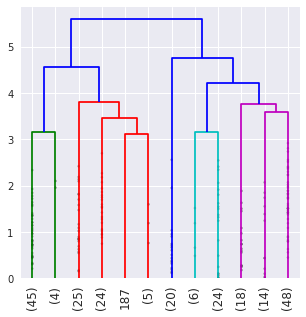

In [27]:
from scipy.cluster import hierarchy
Z = hierarchy.average(M)
plt.figure(figsize=(5,5))
hierarchy.dendrogram(
    Z,    
    truncate_mode='lastp',   # show only the last p merged clusters
    p=12,                    # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
    )   
plt.show()

In [28]:
from scipy.cluster.hierarchy import fcluster
k=4
clusters = fcluster(Z, k, criterion='maxclust')
country_dict = {k: int(v) for k, v in zip(node_list, clusters)}

In [29]:
## delete a couple of marginalized countries 

# del_cty = ['Niue','Martinique','Western Sahara','Haiti','Rwanda','Aruba']
# try:
#     [country_dict.pop(k) for k in del_cty]
# except:
#     pass
# ## delete nodes from the graph 
# try:
#     [G.remove_node(k) for k in del_cty]
# except:
#     pass

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


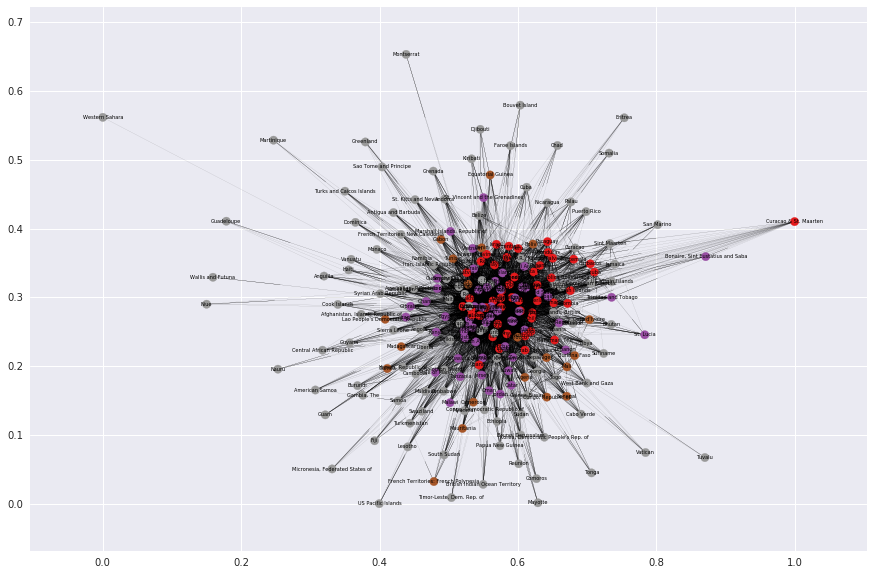

In [30]:
layout = nx.spring_layout(G)
plt.figure(1, figsize=(15,10))
nx.draw_networkx(G,
                 pos=layout,
                 nodelist=list(country_dict.keys()),
                 node_size = 70,  ## change the size of the node, based on degree
                 node_color=list(country_dict.values()),                   ## change color abased on degree
                 width=0.05,
                 font_size=5,
                 cmap='Set1',                                 ## choose one color map http://matplotlib.org/users/colormaps.html
                 )

### Convert directed graph to un_directed graph 

In [34]:
## use adj matrix + its invert, so the edge will be the sum of in and out edge weight 
node_list = G.nodes()
node_list.sort()
A = nx.to_numpy_matrix(G = G,nodelist=node_list,weight='total_weight')
ud_M = A + A.T 
ud_G = nx.from_numpy_matrix(ud_M)
print(nx.info(ud_G))

Name: 
Type: Graph
Number of nodes: 234
Number of edges: 5772
Average degree:  49.3333


In [35]:
## relable node to country name 
maplist = dict(zip(ud_G.nodes(), node_list))
ud_G = nx.relabel_nodes(ud_G,maplist) 
ud_G['United States']['United Kingdom']

{'weight': 0.3955347127148422}

### Networkx community detection method

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


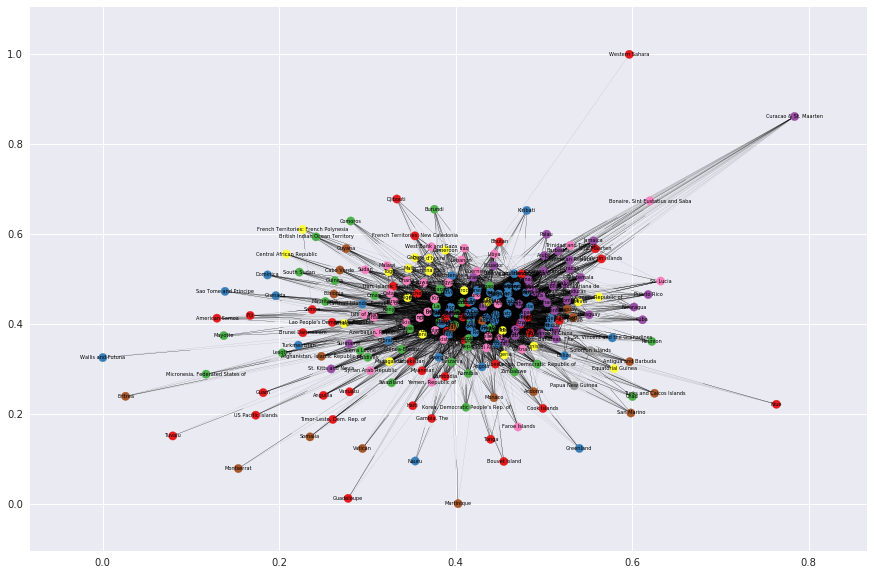

In [36]:
## decompose graph using Louvain algorithm
l_community = community.best_partition(ud_G,weight='weight',resolution=1)
layout = nx.spring_layout(G)
plt.figure(1, figsize=(15,10))
nx.draw_networkx(G,
                 pos=layout,
                 nodelist=list(l_community.keys()),
                 node_size = 70,  ## change the size of the node, based on degree
                 node_color=list(l_community.values()),                   ## change color abased on degree
                 width=0.05,
                 font_size=5,
                 cmap='Set1',                                 ## choose one color map http://matplotlib.org/users/colormaps.html
                 )

## Visualizations

In [ ]:
nx.write_gexf(G, "2015.gexf")

#### 2009
<img src="../pic/2009.png" width=500 hight=500></img>
#### 2015
<img src="../pic/2015.png" width=500 hight=500></img>